## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Оглавление
1. [Подготовка](#One)
2. [Анализ](#Two)
3. [Обучение](#Three)
4. [Тестирование](#Four)
5. [Общий вывод](#Five)

# 1. Подготовка<a class="anchor" id="One"></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict , KFold
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import StandardScaler
import time

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
#базовые библиотеки машинного обучения
from scipy import stats as st 
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, r2_score, mean_absolute_error, make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb

#игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузим данные, делаем столбец datetime индексом, а также сделаем автопарсинг
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(ascending=True, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
# Проверка на монотоность
data.index.is_monotonic

True

In [ ]:
#Выполняем ресемплирование
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


- Как видим у нас срез данных за полгода

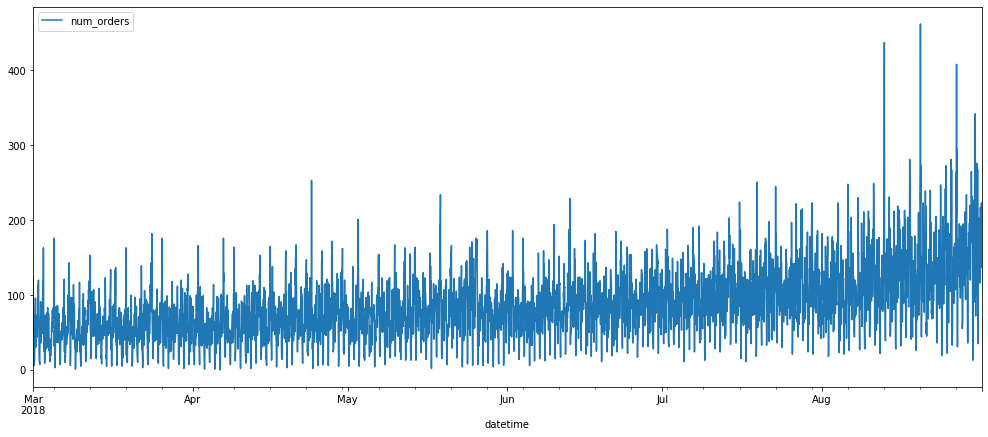

In [ ]:
data.plot(figsize = (17, 7))

In [ ]:
# Добавим признаки

def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
      
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data


# 2. Анализ<a class="anchor" id="Two"></a>

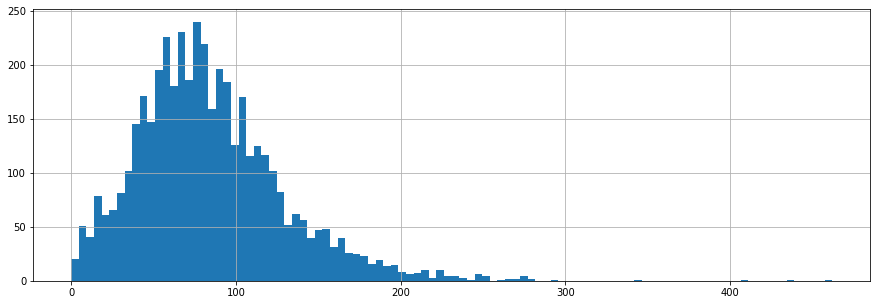

In [ ]:
data['num_orders'].hist(bins = 100, figsize = (15, 5))

In [ ]:
decomposed = seasonal_decompose(data['num_orders'])

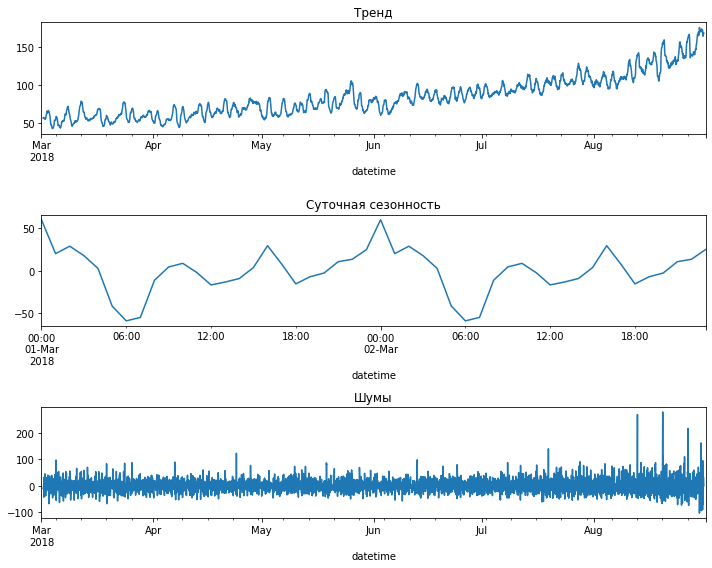

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

decomposed.seasonal = decomposed.seasonal['2018-03-01':'2018-03-02']
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Суточная сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шумы')

plt.tight_layout()

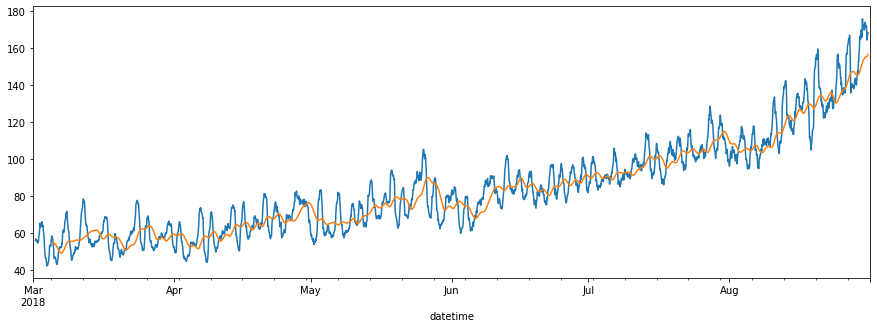

In [ ]:
decomposed.trend.plot(figsize=(15,5))
decomposed.trend.rolling(90).mean().plot()


### Вывод

- Заданный процесс - стахостический нестационарный. 
- График тренда показывает увеличение количества заказов с марта по сентябрь в 3 раза.
- Сезонность - стационарна,связанна со временем суток, в который совершались заказы. Минимальное количество заказов приходится на 6 утра, максимум - в вечерние часы 22-23.
- Шумы практически стационарны, и нарастают к концу временного периода. Возможно это негативно скажется на результатах предсказаний, так как в тестовую выборку войдет как раз последние 10% датасета.

# 3. Обучение <a class="anchor" id="Three"></a>

In [ ]:
# Добавим признаки в модель 
# Похоже что временной ряд имеет недельный цикл, поэтому выбрал кол-во отстающих значений, равным кол-ву часов в неделе
make_features(data, 168, 48)
data = data.dropna()
display(data.head())
data_copy = data.copy()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,53.125000
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.229167
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,55.291667
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,55.895833
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.291667


In [ ]:
#data.plot(figsize=(15,15))
#sns.heatmap(data.corr(), cmap='RdYlGn', center=0, annot=True, square=True)

In [ ]:
# Разделим сет на выбоки
features = data_copy.drop(['num_orders'], axis=1)
target = data_copy['num_orders']

x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [ ]:
# Масштабирование
scaler = StandardScaler()
x_train = pd.DataFrame(data = scaler.fit_transform(x_train), columns = x_train.columns)
x_test =  pd.DataFrame(data = scaler.transform(x_test), columns = x_train.columns)

### LinearRegression

In [ ]:
%%time
start_time = time.time()

lr_model = LinearRegression()

# Значения метрики на кросс валидации
lr_cv_rmse = (cross_val_score(lr_model, 
                             x_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean()*-1)**0.5
print('Значение RMSE для LinearRegression на train =', lr_cv_rmse)

lr_cv_time = time.time() - start_time

Значение RMSE для LinearRegression на train = 21.468525103104344
CPU times: user 1.37 s, sys: 1.13 s, total: 2.5 s
Wall time: 2.49 s


### RandomForestRegressor

In [ ]:
%%time
start_time = time.time()

rf_model = RandomForestRegressor(random_state = 12345)

#Параметры для GridSearch
hyperparams = {'n_estimators': range(60, 100, 10),'max_depth' : range(10, 40, 10)}

#grid_cv_rf = GridSearchCV(rf_model, hyperparams)

tscv = TimeSeriesSplit(n_splits=7)# Делим на 7, по числу дней в неделе
grid_cv_rf = GridSearchCV(rf_model, hyperparams, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

#split_index = TimeSeriesSplit().split(x_train)
#grid_cv_rf = GridSearchCV(rf_model, hyperparams, scoring='neg_mean_squared_error', cv=split_index)



grid_cv_rf.fit(x_train, y_train)
print(grid_cv_rf.best_params_)

# Значения метрики на кросс валидации
rf_cv_rmse = (cross_val_score(rf_model , 
                            x_train, 
                            y_train , 
                            cv=5 , 
                            scoring='neg_mean_squared_error').mean()*-1)**0.5

print('Значение RMSE для Random Forest на train:' , rf_cv_rmse)

rf_cv_time = time.time() - start_time 


Fitting 7 folds for each of 12 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed: 16.6min finished


{'max_depth': 30, 'n_estimators': 70}
Значение RMSE для Random Forest на train: 23.623681776272683
CPU times: user 17min 2s, sys: 892 ms, total: 17min 3s
Wall time: 17min 19s


### XGBoost

In [ ]:
%%time
start_time = time.time()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', gpu_id=0, random_state = 12345)

hyperparams = { 'max_depth': [5, 7, 10],
                'n_estimators': [100, 200]}

grid_xgbst = GridSearchCV(xgb_model, hyperparams, scoring='neg_mean_squared_error', cv=5)

#tscv = TimeSeriesSplit(n_splits=7)# Делим на 7, по числу дней в неделе
#grid_xgbst = GridSearchCV(xgb_model, hyperparams, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

split_index = TimeSeriesSplit().split(x_train)
grid_xgbst = GridSearchCV(xgb_model, hyperparams, scoring='neg_mean_squared_error', cv=split_index)


model_xgboost = grid_xgbst.fit(x_train, y_train)

print('Лучшие гиперпараметры:')
print()
print(grid_xgbst.best_params_)
print()

print("RMSE при разных значениях гиперпараметров:")
print()
means = grid_xgbst.cv_results_['mean_test_score']
stds = grid_xgbst.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_xgbst.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1)** 0.5, params))
print()
xgboost_cv_rmse = (max(means)*-1) ** 0.5
xgboost_cv_time = time.time() - start_time # Записываем время работы ячейки

Лучшие гиперпараметры:

{'max_depth': 5, 'n_estimators': 100}

RMSE при разных значениях гиперпараметров:

22.2393 for {'max_depth': 5, 'n_estimators': 100}
22.2881 for {'max_depth': 5, 'n_estimators': 200}
22.9055 for {'max_depth': 7, 'n_estimators': 100}
22.8879 for {'max_depth': 7, 'n_estimators': 200}
23.6851 for {'max_depth': 10, 'n_estimators': 100}
23.6545 for {'max_depth': 10, 'n_estimators': 200}

CPU times: user 4min 4s, sys: 912 ms, total: 4min 4s
Wall time: 4min 12s


### LightGBM

In [ ]:
%%time
start_time = time.time()

LGBM = LGBMRegressor(random_state=12345, learning_rate=0.1) 
hyperparams = [{'num_leaves':[100, 200], 
                'max_depth':[5,6,7],
                'min_data_in_leaf':[10, 20, 30]}]

#grid_lgbm = GridSearchCV(LGBM, hyperparams, scoring='neg_mean_squared_error', cv=5)

tscv = TimeSeriesSplit(n_splits=7)# Делим на 7, по числу дней в неделе
grid_lgbm = GridSearchCV(LGBM, hyperparams, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

#split_index = TimeSeriesSplit().split(x_train)
#grid_lgbm = GridSearchCV(LGBM, hyperparams, scoring='neg_mean_squared_error', cv=split_index)

grid_lgbm.fit(x_train, y_train)

print('Лучшие гиперпараметры:')
print()
print(grid_lgbm.best_params_)
print()
print("RMSE при разных значениях гиперпараметров:")
print()
means = grid_lgbm.cv_results_['mean_test_score']
stds = grid_lgbm.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_lgbm.cv_results_['params']):
    print("%0.4f for %r"% ((mean*-1)** 0.5, params))
print()

lgbm_cv_rmse = (max(means)*-1) ** 0.5
lgbm_cv_time = time.time() - start_time # Записываем время работы ячейки 

Fitting 7 folds for each of 18 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  2.8min finished


Лучшие гиперпараметры:

{'max_depth': 7, 'min_data_in_leaf': 20, 'num_leaves': 100}

RMSE при разных значениях гиперпараметров:

22.8271 for {'max_depth': 5, 'min_data_in_leaf': 10, 'num_leaves': 100}
22.8271 for {'max_depth': 5, 'min_data_in_leaf': 10, 'num_leaves': 200}
22.7650 for {'max_depth': 5, 'min_data_in_leaf': 20, 'num_leaves': 100}
22.7650 for {'max_depth': 5, 'min_data_in_leaf': 20, 'num_leaves': 200}
22.8640 for {'max_depth': 5, 'min_data_in_leaf': 30, 'num_leaves': 100}
22.8640 for {'max_depth': 5, 'min_data_in_leaf': 30, 'num_leaves': 200}
22.8964 for {'max_depth': 6, 'min_data_in_leaf': 10, 'num_leaves': 100}
22.8964 for {'max_depth': 6, 'min_data_in_leaf': 10, 'num_leaves': 200}
22.8053 for {'max_depth': 6, 'min_data_in_leaf': 20, 'num_leaves': 100}
22.8053 for {'max_depth': 6, 'min_data_in_leaf': 20, 'num_leaves': 200}
22.7359 for {'max_depth': 6, 'min_data_in_leaf': 30, 'num_leaves': 100}
22.7359 for {'max_depth': 6, 'min_data_in_leaf': 30, 'num_leaves': 200}
22.9537

### SGDRegressor

In [ ]:
%%time
start_time = time.time()

sgd_model = SGDRegressor()

# Значения метрики на кросс валидации
sgd_cv_rmse = (cross_val_score(sgd_model, 
                             x_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean()*-1)**0.5
print('Значение RMSE для LinearRegression на train =', sgd_cv_rmse)

sgd_cv_time = time.time() - start_time

Значение RMSE для LinearRegression на train = 21.728660246286662
CPU times: user 775 ms, sys: 344 ms, total: 1.12 s
Wall time: 1.09 s


- Добавил признаки для обучения моделей:
    - час
    - день
    - день недели
    - месяц
    - отстающие значения
    - скользящее среднее
- Выбрал модели для обучения : LinearRegression, RandomForestRegressor, XGBoost, LightGBM, SGDRegressor


# 4. Тестирование<a class="anchor" id="Four"></a>

### LinearRegression

In [ ]:
%%time
start_time = time.time()

lr_model.fit(x_train, y_train)
lr_rmse = mse(y_test, lr_model.predict(x_test))**0.5
print('Значение RMSE для LinearRegression на test =' , lr_rmse)

lr_time = time.time() - start_time # Записываем время работы ячейки

Значение RMSE для LinearRegression на test = 34.25980525349294
CPU times: user 228 ms, sys: 176 ms, total: 404 ms
Wall time: 399 ms


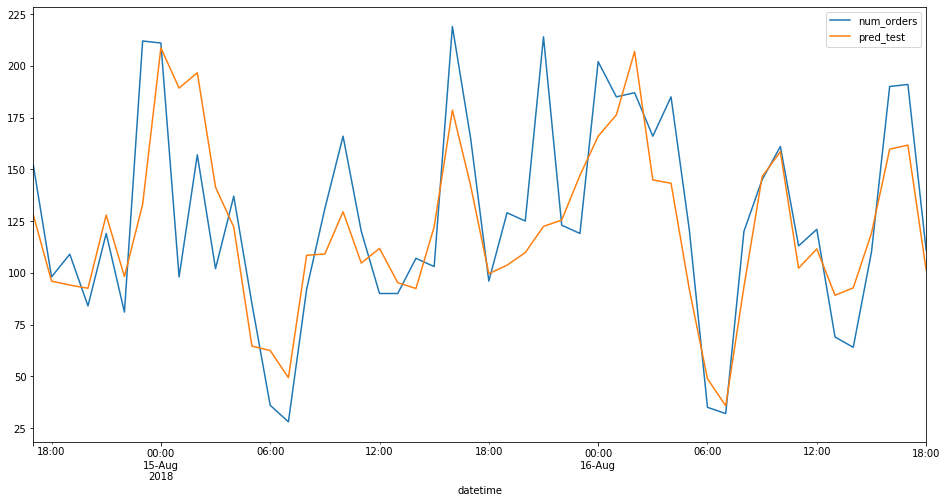

In [ ]:
#строим график факт/предсказанное
data_test = pd.DataFrame(y_test)
data_test['pred_test'] = lr_model.predict(x_test).tolist()
data_test[10:60].plot(figsize=(16,8))

### RandomForestRegressor

In [ ]:
%%time
start_time = time.time()

rf_model = RandomForestRegressor( max_depth=30, n_estimators=90, random_state = 12345) 

# Модель на тестовой выборке

rf_model.fit(x_train, y_train)
rf_rmse = mse(y_test, rf_model.predict(x_test))**0.5
print('Значение RMSE для Random Forest на test:' , rf_rmse)

rf_time = time.time() - start_time # Записываем время работы ячейки 

Значение RMSE для Random Forest на test: 39.49820154937993
CPU times: user 33.2 s, sys: 16 ms, total: 33.2 s
Wall time: 33.6 s


Text(0.5, 0, 'Относительные значения')

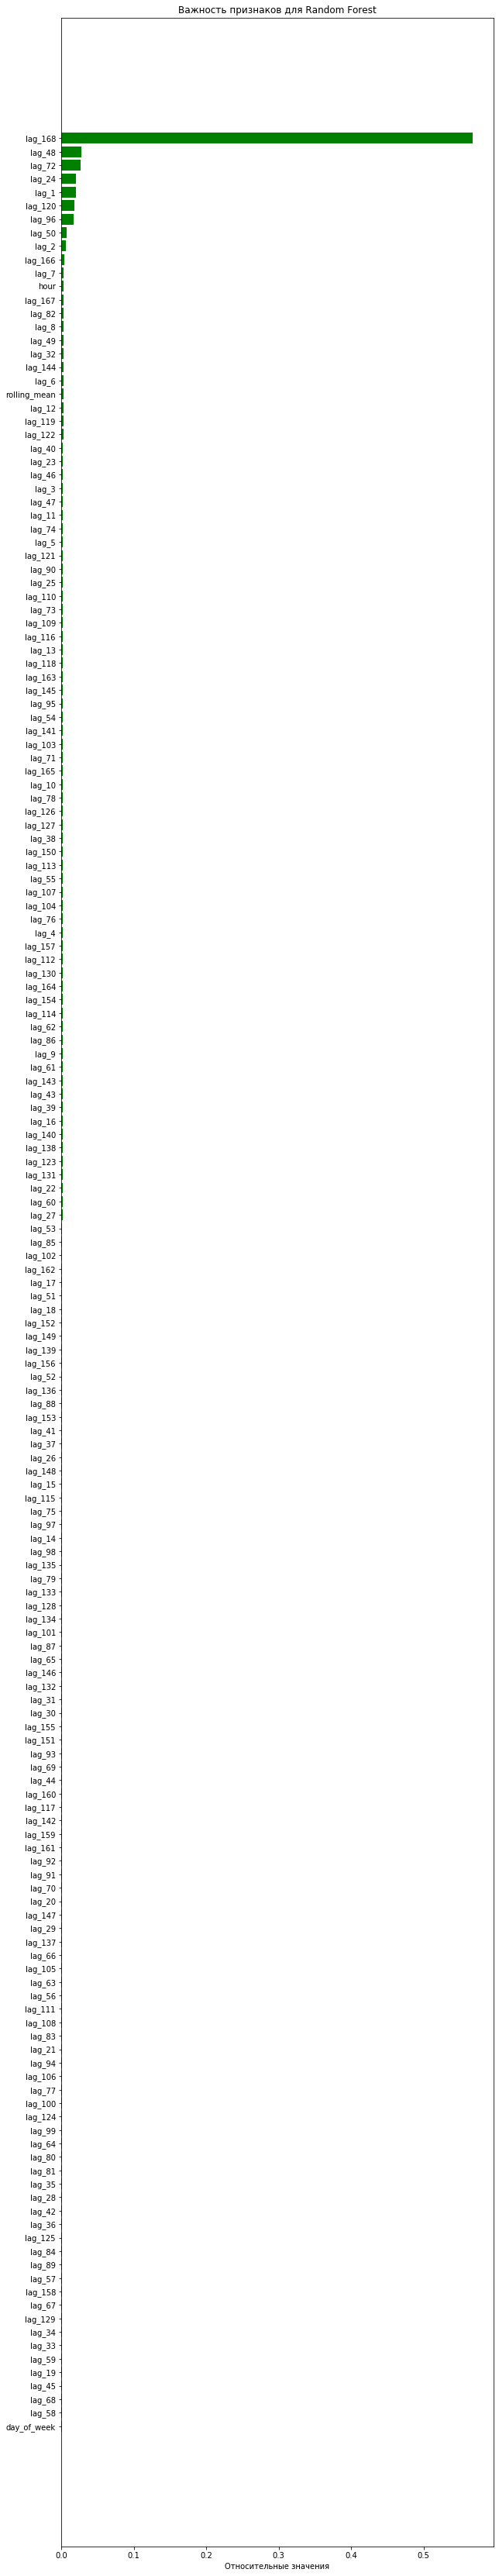

In [ ]:
features=x_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 60))
plt.title('Важность признаков для Random Forest')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительные значения')

### XGBoost

In [ ]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Модель на тестовой выборке
start_time = time.time()
xgb_test = xgb.XGBRegressor(objective ='reg:squarederror', max_depth=7, n_estimators=100, gpu_id=0, random_state = 12345)

# Обучаем модель
xgb_test.fit(x_train, y_train)  
# Делаем предсказания
preds = xgb_test.predict(x_test)
xgboost_rmse = mse(y_test, preds)**0.5

print('Значение  RMSE для XGBoost на test:', xgboost_rmse)

xgboost_time = time.time() - start_time # Записываем время работы ячейки

Значение  RMSE для XGBoost на test: 39.28498701610785
CPU times: user 5.82 s, sys: 16 ms, total: 5.83 s
Wall time: 5.86 s


Text(0.5, 0, 'Относительные значения')

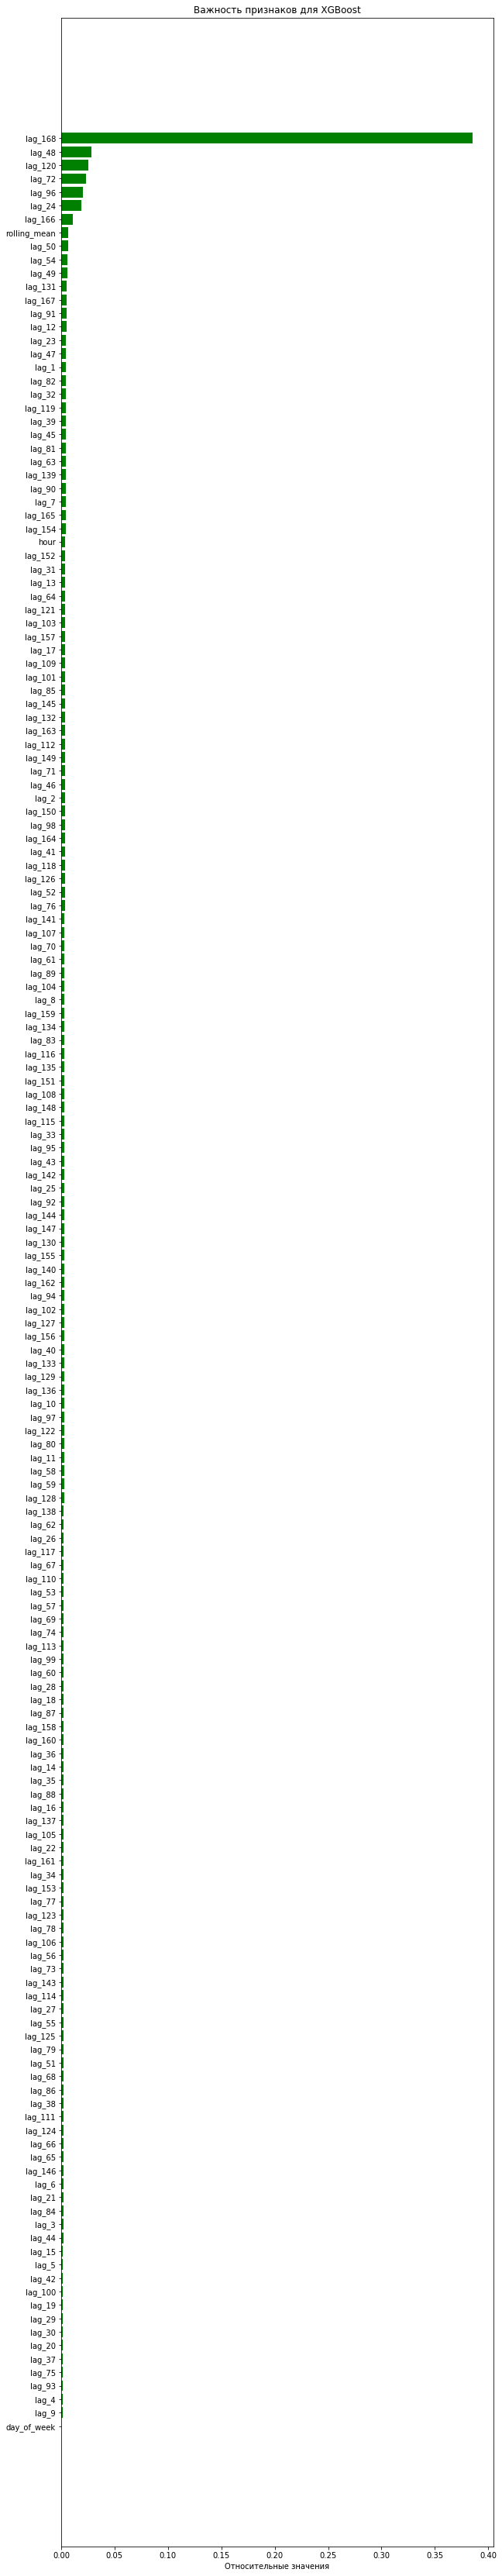

In [ ]:
features = x_train.columns
importances = xgb_test.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 60))
plt.title('Важность признаков для XGBoost')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительные значения')

### LightGBM

In [ ]:
%%time
# Модель на тестовой выборке
start_time = time.time()
LGBM_test = LGBMRegressor(random_state=12345, learning_rate=0.1, depth=5, min_data_in_leaf=10, num_leaves=100)

# Обучаем модель
LGBM_test.fit(x_train, y_train)  
# Делаем предсказания
preds = LGBM_test.predict(x_test)
lgbm_rmse = mse(y_test, preds)**0.5

print('Значение RMSE для LightGBM на test:', lgbm_rmse)

lgbm_time = time.time() - start_time # Записываем время работы ячейки

Значение RMSE для LightGBM на test: 37.59240303694247
CPU times: user 9.43 s, sys: 76 ms, total: 9.51 s
Wall time: 9.63 s


Text(0.5, 0, 'Относительные значения')

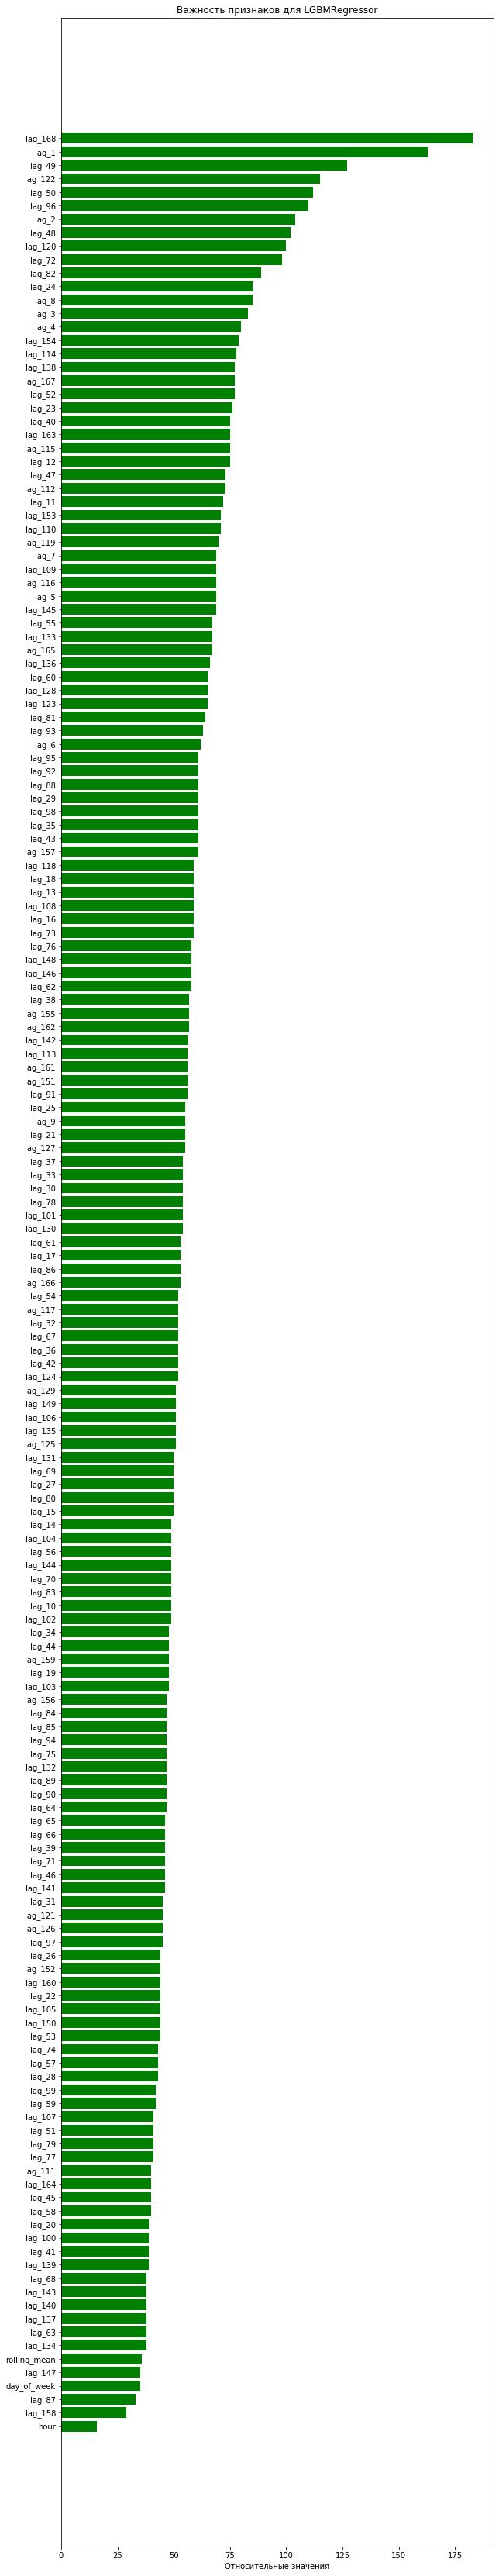

In [ ]:
features = x_train.columns
importances = LGBM_test.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 60))
plt.title('Важность признаков для LGBMRegressor')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительные значения')

In [ ]:
#Проверим модель на адекватность константной моделью
pred_mean = np.full(y_test.shape, y_train.mean())
print("RMSE константной модели:", mse(y_test, pred_mean)**0.5)

RMSE константной модели: 84.45113423436631


- RMSE константной модели почти в 2 раза выше. Это говорит, что выбранная модель адекватна

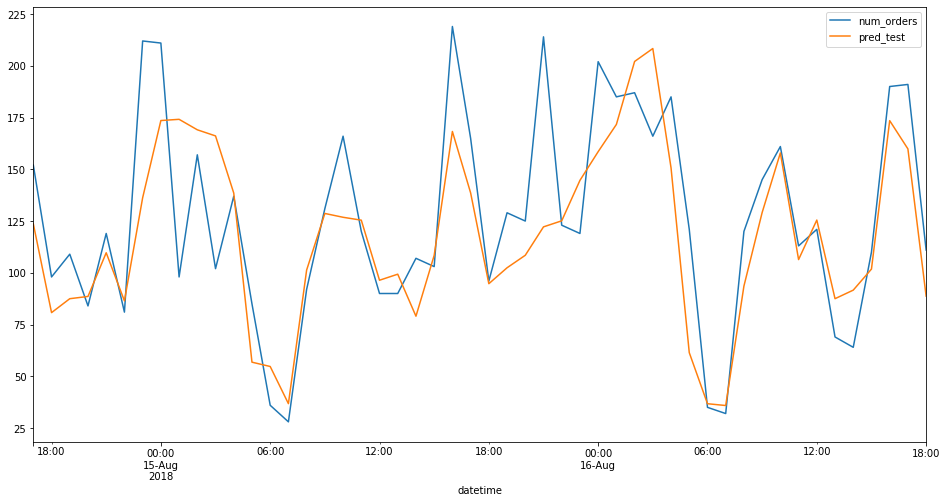

In [ ]:
#строим график факт/предсказанное
data_test = pd.DataFrame(y_test)
data_test['pred_test'] = preds.tolist()
data_test[10:60].plot(figsize=(16,8))

- видим, в пиковые часы модель предсказывает меньшее количество заказов (с 8 до 11 утра и с 9 до 12 вечера)

### SGDRegressor

In [ ]:
%%time
start_time = time.time()
sgd_model = SGDRegressor()
sgd_model.fit(x_train, y_train)
predict_sgd_model = sgd_model.predict(x_test)
sgd_rmse = mse(y_test, predict_sgd_model)**(0.5)

print('Значение RMSE для SGD на test:', sgd_rmse)
sgd_time = time.time() - start_time # Записываем время работы ячейки

Значение RMSE для SGD на test: 36.422202095897575
CPU times: user 104 ms, sys: 43 µs, total: 104 ms
Wall time: 106 ms


In [ ]:
# Записываем результаты в словарь
dict_results = {'Model': ['LinearRegression,' , 'Random_Forest' , 'LightGBM' ,'XGBoost', 'SDG'],
               'RMSE_CV':[lr_cv_rmse , rf_cv_rmse , lgbm_cv_rmse , xgboost_cv_rmse, sgd_cv_rmse] ,
               'RMSE_test': [lr_rmse , rf_rmse , lgbm_rmse , xgboost_rmse, sgd_rmse] , 
               'Working_time_CV' : [lr_cv_time , rf_cv_time , lgbm_cv_time , xgboost_cv_time, sgd_cv_time ],
               'Working_time_test': [lr_time , rf_time , lgbm_time , xgboost_time, sgd_time]
               } 
Results = pd.DataFrame(dict_results)
Results

,Model,RMSE_CV,RMSE_test,Working_time_CV,Working_time_test
0,"LinearRegression,",21.468525,34.259805,2.490846,0.399210
1,Random_Forest,23.623682,39.498202,1039.661711,33.558913
2,LightGBM,22.728191,37.592403,167.629418,9.625454
3,XGBoost,22.239304,39.284987,252.473008,5.859566
4,SDG,21.728660,36.422202,1.092653,0.106363


### Вывод

- В результатате тестирования лучший RMSE у LightGBM. По скорости тоже одна из самых быстрвх моделей.
- Далее идут модели RandomForest и XGBoost.

# 5. Общий вывод<a class="anchor" id="Five"></a>

В ходе работы над проектом:

- были загружены данные из файла, изучены, ресемплированы по одному часу.
- данные проанализированы: изучены тренды и сезонность.
- добавлены новые календарные признаки, отстающие значения, рассчитано скользящее среднее
- данные разделены на обучающую и тестовую выборки.
- обучено несколько моделей с разными гипермпараметрами
- модели проверена на тестовой выборке
- по RMSE выбрана лучшая - LightGBM, результат удовлетворительный RMSE = 42.27
